In [ ]:
!nvidia-smi

Thu Feb 11 10:31:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/MyDrive/Tesis_Maestria/Experiment_Pytorch_W2V/

/content/drive/MyDrive/Tesis_Maestria/Experiment_Pytorch_W2V


#W2V Pytorch 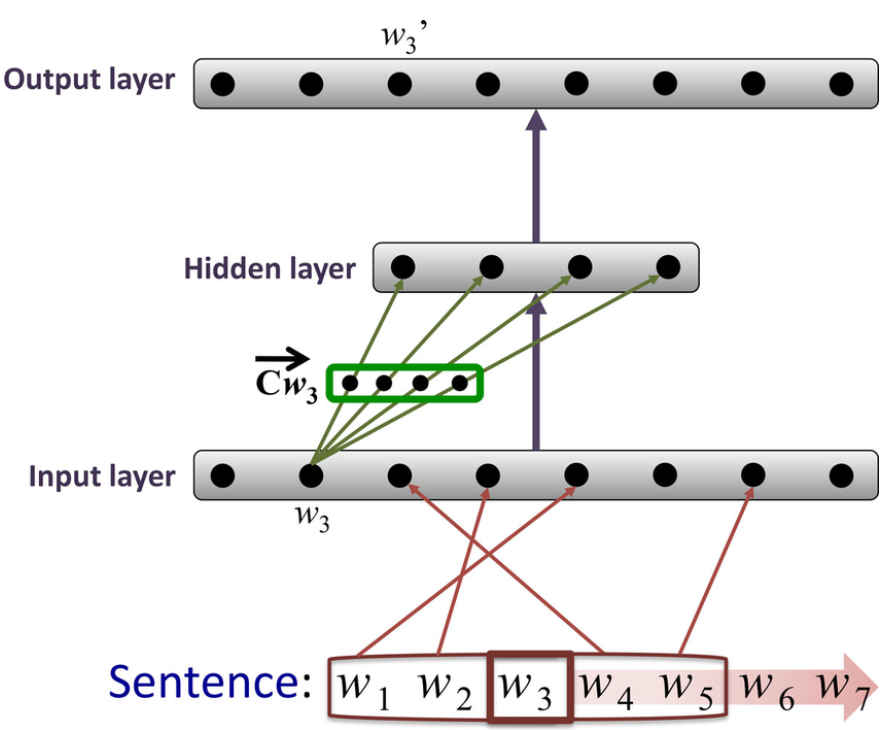

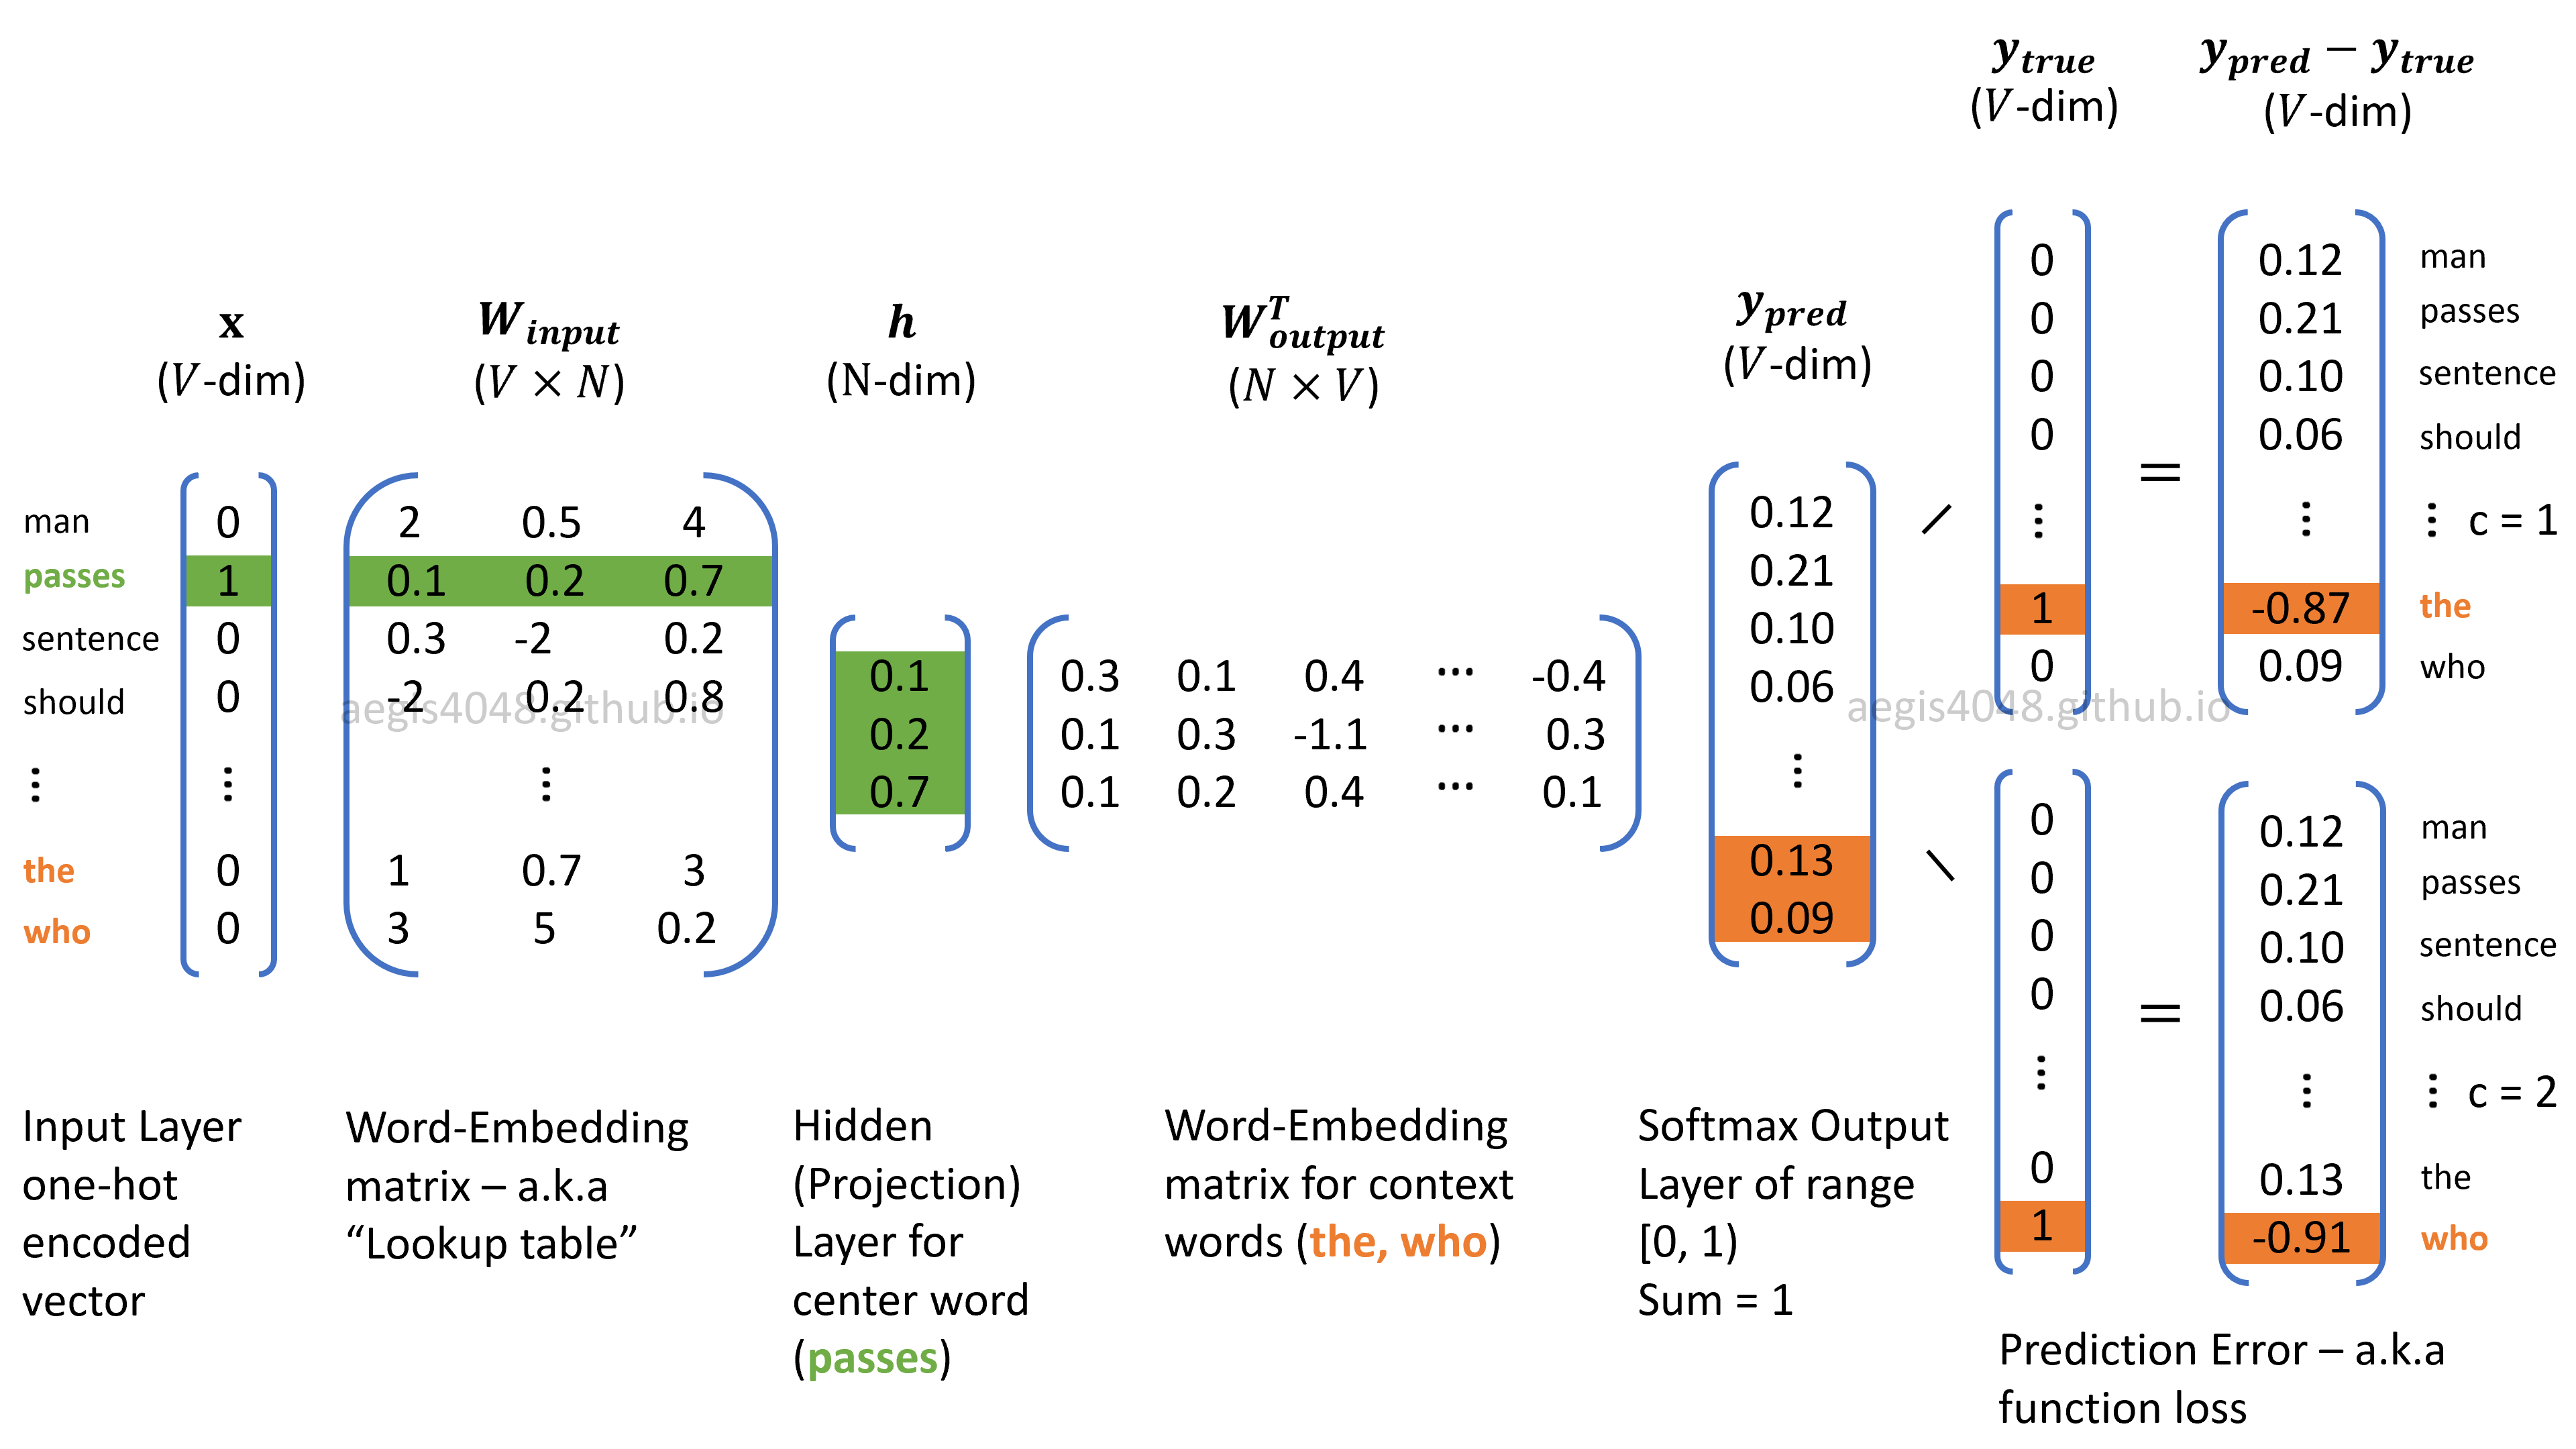

##Corpus - extraction an corpus

In [ ]:
import torch
from torch.optim import SGD
from torch.autograd import Variable, profiler
import numpy as np
import torch.functional as F
import torch.nn.functional as F

In [ ]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
]

###Creating Vocabulary: list of unique words with assigned indices
Implementation to clean data:


*   Normalization
*   Remove some punctuation

Only concentrate in tokenize it, generates us a list of tokens:



In [ ]:
txt = "welcome to the jungle"
x = txt.split()
print(x)

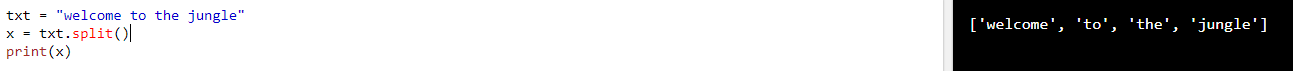


In [ ]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

In [ ]:
tokenized_corpus

[['he', 'is', 'a', 'king'],
 ['she', 'is', 'a', 'queen'],
 ['he', 'is', 'a', 'man'],
 ['she', 'is', 'a', 'woman'],
 ['warsaw', 'is', 'poland', 'capital'],
 ['berlin', 'is', 'germany', 'capital'],
 ['paris', 'is', 'france', 'capital']]

###Create two dictionaries for mapping between word and index

In [ ]:
words = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in words:
            words.append(token)

word2idx = {w: idx for (idx, w) in enumerate(words)}
idx2word = {idx: w for (idx, w) in enumerate(words)}

vocabulary_size = len(word2idx)

In [ ]:
words

['he',
 'is',
 'a',
 'king',
 'she',
 'queen',
 'man',
 'woman',
 'warsaw',
 'poland',
 'capital',
 'berlin',
 'germany',
 'paris',
 'france']

In [ ]:
word2idx?

In [ ]:
word2idx

{'a': 2,
 'berlin': 11,
 'capital': 10,
 'france': 14,
 'germany': 12,
 'he': 0,
 'is': 1,
 'king': 3,
 'man': 6,
 'paris': 13,
 'poland': 9,
 'queen': 5,
 'she': 4,
 'warsaw': 8,
 'woman': 7}

In [ ]:
idx2word

{0: 'he',
 1: 'is',
 2: 'a',
 3: 'king',
 4: 'she',
 5: 'queen',
 6: 'man',
 7: 'woman',
 8: 'warsaw',
 9: 'poland',
 10: 'capital',
 11: 'berlin',
 12: 'germany',
 13: 'paris',
 14: 'france'}

###list of pairs Center, Context indices:

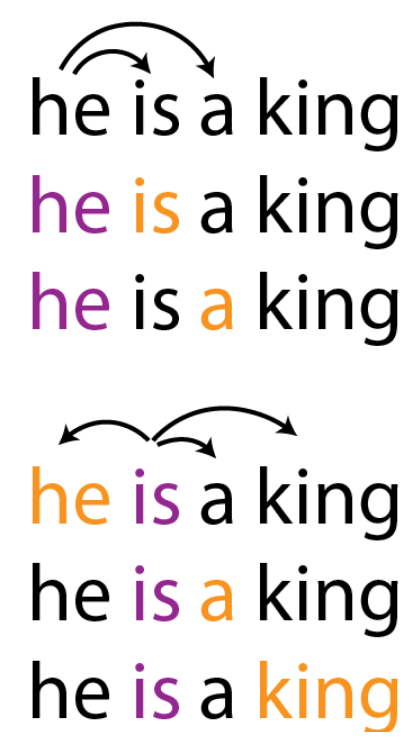

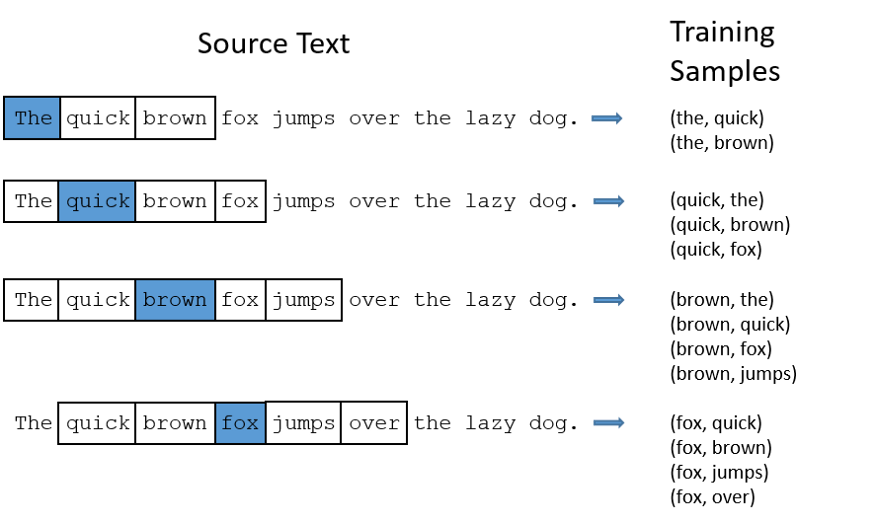

In [ ]:
import numpy as np

window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    print('-------indices-------', range(len(indices)))
    for center_word_pos in range(len(indices)):
    # for each window position
      for w in range(-window_size, window_size + 1):
          context_word_pos = center_word_pos + w
          print(center_word_pos, context_word_pos)
          # make sure not jump out sentence
          if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
              continue
          context_word_idx = indices[context_word_pos]
          print('-----context_word_idx-------', context_word_idx)
          idx_pairs.append((indices[center_word_pos], context_word_idx))
          print('-----idx_pairs-------', idx_pairs)

-------indices------- range(0, 4)
0 -2
0 -1
0 0
0 1
-----context_word_idx------- 1
-----idx_pairs------- [(0, 1)]
0 2
-----context_word_idx------- 2
-----idx_pairs------- [(0, 1), (0, 2)]
1 -1
1 0
-----context_word_idx------- 0
-----idx_pairs------- [(0, 1), (0, 2), (1, 0)]
1 1
1 2
-----context_word_idx------- 2
-----idx_pairs------- [(0, 1), (0, 2), (1, 0), (1, 2)]
1 3
-----context_word_idx------- 3
-----idx_pairs------- [(0, 1), (0, 2), (1, 0), (1, 2), (1, 3)]
2 0
-----context_word_idx------- 0
-----idx_pairs------- [(0, 1), (0, 2), (1, 0), (1, 2), (1, 3), (2, 0)]
2 1
-----context_word_idx------- 1
-----idx_pairs------- [(0, 1), (0, 2), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1)]
2 2
2 3
-----context_word_idx------- 3
-----idx_pairs------- [(0, 1), (0, 2), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3)]
2 4
3 1
-----context_word_idx------- 1
-----idx_pairs------- [(0, 1), (0, 2), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (3, 1)]
3 2
-----context_word_idx------- 2
-----idx_pairs----

###FORWARD PASS

###Input Layer: the center word encoded in one-hot manner. It dimensions are [1, vocabulary_size]

In [ ]:
def get_word_embedding(word):
    word_vec_one_hot = np.zeros(vocabulary_size)
    word_vec_one_hot[word2idx[word]] = 1
    return word_vec_one_hot

###Hidden layer makes our v vectors

In [ ]:
embedding_dims = 10
window_size = 2

In [ ]:
def train_generator():
    for sentence in corpus:
        words = sentence.split()
        indices = [word2idx[w] for w in words]
        for i in range(len(indices)):
            # center word, context
            # i is center word index
            for w in range(-window_size, window_size + 1):
                context_idx = i + w
                if context_idx < 0 or context_idx >= len(indices) or i == context_idx:
                    continue
                center_vec_one_hot = np.zeros(vocabulary_size)
                center_vec_one_hot[indices[i]] = 1
                
                context_idx = indices[context_idx]
                yield center_vec_one_hot, context_idx

#log_softmax

Function to an n-dimensional input Tensor. The LogSoftmax formulation can be simplified as:

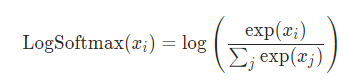

In [ ]:
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 500
learning_rate = 0.01

for epo in range(num_epochs):
    avg_loss = 0
    samples = 0
    #center_vec_one_hot = data
    #context_idx = target
    for data, target in train_generator():
        x = Variable(torch.from_numpy(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())
        samples += len(y_true)
        
        a1 = torch.matmul(W1, x) #words vectors
        a2 = torch.matmul(W2, a1) 

        log_softmax = F.log_softmax(a2, dim=0)

        network_pred_dist = F.softmax(log_softmax, dim=0)
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        print('-----loss-----', )
        avg_loss += loss.item()

        #Backward pass

        loss.backward()

        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
        
    if epo % 50 == 0:
        print(f'Loss at epo {epo}:, {avg_loss / samples}')

5.61014133663848
1.6778623368058885
1.6245756915637426
1.6132153647286551
1.608571548972811
1.605936931712287
1.6041006565093994
1.6026471717017037
1.601406342642648
1.6002996163708822
1.5992869334561484


In [ ]:
!pip install scikit-plot

In [ ]:
%matplotlib inline
import scikitplot as skplt
from scikitplot.decomposition import plot_pca_2d_projection
from sklearn.decomposition import PCA

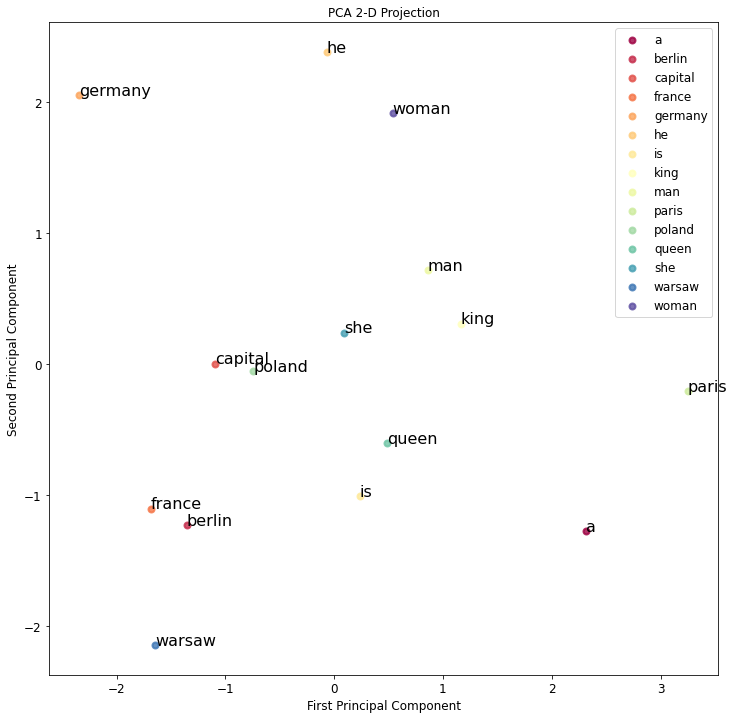

In [ ]:
pca = PCA(n_components=2)
pca.fit(W1.data.numpy().T)
proj = pca.transform(W1.data.numpy().T)
ax = plot_pca_2d_projection(pca, W1.data.numpy().T, np.array(words), feature_labels=words, figsize=(12,12), text_fontsize=12)
# ax.legend(None)
for i, txt in enumerate(words):
    ax.annotate(txt, (proj[i,0], proj[i,1]), size=16)

In [ ]:
def get_word_vector_v(word):
    return W1[:, word2idx[word]].data.numpy()

def get_word_vector_u(word):
    return W2[word2idx[word],:].data.numpy()

# Poland to Warsaw is like Germany to ?

In [ ]:
pol = 1 * get_word_vector_v('poland') + 1 * get_word_vector_u('poland')
ger = 1 * get_word_vector_v('germany') + 1 * get_word_vector_u('germany') 
waw = 1 * get_word_vector_v('warsaw') + 1 * get_word_vector_u('warsaw') 

ber = 1 * get_word_vector_v('berlin') 

yyy = waw - pol + ger
print('pol', pol)
print('ger', ger)
print('waw', waw)
print('yyy', yyy)
print('Ber', ber)

NameError: ignored

In [ ]:
from scipy.spatial.distance import cosine
distances = [(v, cosine(yyy, 1 * get_word_vector_u(v) + 1 * get_word_vector_v(v))) for v in words]

# Poland to Warsaw is like Germany to Berlin

In [ ]:
distances

[('he', 0.9331388473510742),
 ('is', 0.7533863931894302),
 ('a', 1.3120140433311462),
 ('king', 1.4005908966064453),
 ('she', 1.035015806555748),
 ('queen', 1.3703261017799377),
 ('man', 0.9737895932048559),
 ('woman', 1.4103586971759796),
 ('warsaw', 0.651348203420639),
 ('poland', 0.8289868384599686),
 ('capital', 0.36495769023895264),
 ('berlin', 0.17492806911468506),
 ('germany', 0.057211995124816895),
 ('paris', 1.2153820097446442),
 ('france', 0.7811065316200256)]

# In what context Paris appears?

In [ ]:
context_to_predict = get_word_vector_v('paris')
hidden = Variable(torch.from_numpy(context_to_predict)).float()
a = torch.matmul(W2, hidden)
probs = F.softmax(a, dim=0).data.numpy()
for context, prob in zip(words, probs):
    print(f'{context}: {prob:.2f}')

he: 0.00
is: 0.44
a: 0.00
king: 0.00
she: 0.00
queen: 0.00
man: 0.00
woman: 0.00
warsaw: 0.00
poland: 0.00
capital: 0.00
berlin: 0.00
germany: 0.00
paris: 0.00
france: 0.55
